In [7]:
from src.functions import *
from scipy.optimize import curve_fit
from joblib import Parallel, delayed

In [8]:
# Fit function
def fit_func(n, a, k):
    return a * 2**(-k * n)

In [9]:
T = 0.5
num_random_models = 100

In [10]:
qubits_range = np.array([3, 4, 5, 6, 7])
len_qubits_range = len(qubits_range)

In [11]:
delta_random_arr = np.zeros((len_qubits_range, num_random_models))
delta_local_arr = np.zeros((len_qubits_range, num_random_models))
delta_quantum_arr = np.zeros((len_qubits_range, num_random_models))
delta_mismatched_quantum_arr = np.zeros((len_qubits_range, num_random_models))
delta_fixed_gamma_arr = np.zeros((len_qubits_range, num_random_models))

for n_index, n in tqdm(enumerate(qubits_range)):

    def compute_delta(seed, method):
        m = RandomIsingModel(n, seed=seed) # set the seed for reproducibility
        if method == 'quantum':
            proposal_mat = get_proposal_mat_quantum_layden(m)
        elif method == 'local':
            proposal_mat = get_proposal_mat_local(m)
        elif method == 'random':
            proposal_mat = get_proposal_mat_random(m)
        elif method == 'mismatched':
            m_mismatched = RandomIsingModel(n, seed=seed+num_random_models) # set the seed for reproducibility
            proposal_mat = get_proposal_mat_quantum_layden(m_mismatched)
        elif method == 'fixed_gamma':
            proposal_mat = get_proposal_mat_quantum_layden(m, gamma_lims=(0.05, 0.05), gamma_steps=1)
        P = get_transition_matrix(m, T, proposal_mat)
        return get_delta(P)

    delta_random_arr[n_index] = Parallel(n_jobs=-1)(delayed(compute_delta)(seed, 'random') for seed in range(num_random_models))
    delta_local_arr[n_index] = Parallel(n_jobs=-1)(delayed(compute_delta)(seed, 'local') for seed in range(num_random_models))
    delta_quantum_arr[n_index] = Parallel(n_jobs=-1)(delayed(compute_delta)(seed, 'quantum') for seed in range(num_random_models))
    delta_mismatched_quantum_arr[n_index] = Parallel(n_jobs=-1)(delayed(compute_delta)(seed, 'mismatched') for seed in range(num_random_models))
    delta_fixed_gamma_arr[n_index] = Parallel(n_jobs=-1)(delayed(compute_delta)(seed, 'fixed_gamma') for seed in range(num_random_models))

5it [00:57, 11.42s/it]


In [12]:
# Take an average over random Ising instances
delta_random_arr_avg = np.mean(delta_random_arr, axis=1)
delta_random_arr_std = np.std(delta_random_arr, axis=1)

delta_local_arr_avg = np.mean(delta_local_arr, axis=1)
delta_local_arr_std = np.std(delta_local_arr, axis=1)

delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=1)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=1)

delta_mismatched_quantum_arr_avg = np.mean(delta_mismatched_quantum_arr, axis=1)
delta_mismatched_quantum_arr_std = np.std(delta_mismatched_quantum_arr, axis=1)

delta_fixed_gamma_arr_avg = np.mean(delta_fixed_gamma_arr, axis=1)
delta_fixed_gamma_arr_std = np.std(delta_fixed_gamma_arr, axis=1)

In [13]:
# plt.plot(delta_random_arr_avg, label='random')
# plt.plot(delta_local_arr_avg, label='local')
# plt.plot(delta_quantum_arr_avg, label='quantum')
# plt.plot(delta_mismatched_quantum_arr_avg, label='mismatched')
# plt.legend()
# plt.yscale('log')
# plt.show()

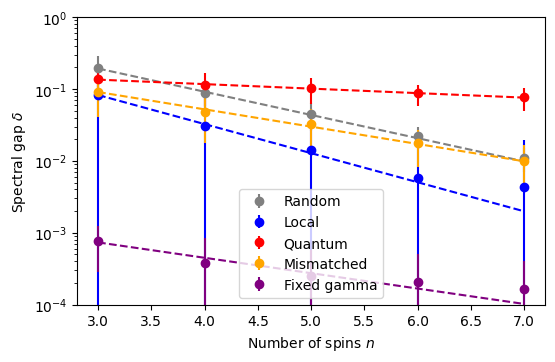

In [14]:
fig = plt.figure(figsize=(figure_size_x, figure_size_y))

# Fit the data with the defined fit function
popt_random, pcov_random = curve_fit(fit_func, qubits_range, delta_random_arr_avg, maxfev=5000)
popt_local, pcov_local = curve_fit(fit_func, qubits_range, delta_local_arr_avg, maxfev=5000)
popt_quantum, pcov_quantum = curve_fit(fit_func, qubits_range, delta_quantum_arr_avg, maxfev=5000)
popt_mismatched, pcov_mismatched = curve_fit(fit_func, qubits_range, delta_mismatched_quantum_arr_avg, maxfev=5000)
popt_fixed_gamma, pcov_fixed_gamma = curve_fit(fit_func, qubits_range, delta_fixed_gamma_arr_avg, maxfev=5000)


# Generate fit curves
fit_random = fit_func(qubits_range, *popt_random)
fit_local = fit_func(qubits_range, *popt_local)
fit_quantum = fit_func(qubits_range, *popt_quantum)
fit_mismatched = fit_func(qubits_range, *popt_mismatched)
fit_fixed_gamma = fit_func(qubits_range, *popt_fixed_gamma)


# Plot the data with error bars
plt.errorbar(qubits_range, delta_random_arr_avg, yerr=delta_random_arr_std, fmt='o', color='grey', label='Random')
plt.errorbar(qubits_range, delta_local_arr_avg, yerr=delta_local_arr_std, fmt='o', color='blue', label='Local')
plt.errorbar(qubits_range, delta_quantum_arr_avg, yerr=delta_quantum_arr_std, fmt='o', color='red', label='Quantum')
plt.errorbar(qubits_range, delta_mismatched_quantum_arr_avg, yerr=delta_mismatched_quantum_arr_std, fmt='o', color='orange', label='Mismatched')
plt.errorbar(qubits_range, delta_fixed_gamma_arr_avg, yerr=delta_fixed_gamma_arr_std, fmt='o', color='purple', label='Fixed gamma')

# Plot the fits
plt.plot(qubits_range, fit_random, '--', color='grey')
plt.plot(qubits_range, fit_local, '--', color='blue')
plt.plot(qubits_range, fit_quantum, '--', color='red')
plt.plot(qubits_range, fit_mismatched, '--', color='orange')
plt.plot(qubits_range, fit_fixed_gamma, '--', color='purple')

plt.yscale('log')

plt.ylim([0.0001, 1])

# Customize the plot
plt.xlabel('Number of spins $n$')
plt.ylabel('Spectral gap $\delta$')
plt.legend()
plt.show()

In [15]:
# Extract and print the k factors and their uncertainties
k_random, k_random_unc = popt_random[1], np.sqrt(pcov_random[1, 1])
k_local, k_local_unc = popt_local[1], np.sqrt(pcov_local[1, 1])
k_quantum, k_quantum_unc = popt_quantum[1], np.sqrt(pcov_quantum[1, 1])
k_mismatched, k_mismatched_unc = popt_mismatched[1], np.sqrt(pcov_mismatched[1, 1])
k_fixed_gamma, k_fixed_gamma_unc = popt_fixed_gamma[1], np.sqrt(pcov_fixed_gamma[1, 1])

In [16]:
print(f"k factor for Random: {k_random} ± {k_random_unc}")
print(f"k factor for Local: {k_local} ± {k_local_unc}")
print(f"k factor for Quantum: {k_quantum} ± {k_quantum_unc}")
print(f"k factor for Mismatched: {k_mismatched} ± {k_mismatched_unc}")
print(f"k factor for Fixed gamma: {k_fixed_gamma} ± {k_fixed_gamma_unc}")

k factor for Random: 1.0722422620149146 ± 0.021630776446308578
k factor for Local: 1.3423179624540562 ± 0.07294796827453033
k factor for Quantum: 0.20758389329055466 ± 0.012622735810976867
k factor for Mismatched: 0.7996561238887373 ± 0.04445763356180266
k factor for Fixed gamma: 0.7104556951091348 ± 0.11105264344149994
